# Data Fusion Part II

Welcome to Part II of data fusion, where we explore how LiDAR-camera projection can enhance our perception capabilities. When it comes to 3D object detection, LiDAR reigns supreme in depth measurement, surpassing even advanced stereo vision techniques. It delivers a wealth of 3D geometric information, allowing us to extract details like volume, surface normals, curvature, and convex hull – invaluable for understanding the scene. Moreover, LiDAR's strength lies in its resilience to lighting changes, unlike cameras. However, its sparse representation poses a challenge. Cameras, on the other hand, excel in capturing rich color and high-resolution details, crucial for tasks like facial recognition under optimal conditions. By cleverly merging these diverse sensor modalities through LiDAR-camera fusion, we unlock powerful synergies that dramatically elevate our 3D object detection performance. In Part II went over on how to project from a lidar 3D point to its 2D Pixel coordinate using the projection formula. 

$$
Y = P \cdot R_0 \cdot [R | t] \cdot X
$$

## Advanced Sensor Fusion: Exploiting the Projection Matrix in the Context of PointPainting

In this section, we delve into the multifaceted applications enabled by the projection matrix within the domain of sensor fusion. A interesting example of its potential is exemplified in the innovative approach adopted in the seminal work "PointPainting." This methodology integrates LiDAR and camera projections to generate semantic mappings of images to decoreate points in 3D with a class label. 

### Theoretical Underpinnings of PointPainting

LiDAR-camera projection enables us to map pixel-level semantic labels from an image onto corresponding 3D LiDAR points. This allows us to enrich the point cloud with semantic information, enhancing our understanding of the scene and facilitating tasks like object segmentation and autonomous navigation. This technique, explored in works like PointPainting, offers promising avenues for further research in 3D scene analysis.

### Methodological Approach in Our Analysis

 Thisimplementation will build upon previous functions established in Part I, encapsulated within `data_fusion_utils.py`. The objective is to methodically transform our dataset from an NxL matrix format (where 'N' signifies the number of LiDAR points and 'L' represents the array of LiDAR attributes, such as x, y, z coordinates, reflectance, intensity, etc.) to an enhanced Nx(L + C) matrix configuration. In this new format, 'C' represents an additional feature dimension, providing semantic class information for each LiDAR point based on the aforementioned image-to-point cloud mapping.

This approach does not merely extend the dimensional complexity of our dataset; it fundamentally redefines our perceptual and analytical capabilities by fusing the high-resolution spatial data from LiDAR with the contextual and semantic richness derived from optical imaging.


![Point Painting](../Doc_Images/PointPainting_Overview.png)

Read the Paper Here: [PointPainting: Sequential Fusion for 3D Object Detection](https://arxiv.org/abs/1911.10150)



Lets start by importing some libaries

In [2]:
import numpy as np
import glob
import open3d as o3d
import matplotlib.pyplot as plt
import cv2
#Import all functions
from data_fusion_utils import *

Next lets load our lidar and image data and get some visuals, we will work with index 0 

In [4]:
#Lets load lidar data
lidar_data_path = "../DATA/lidar_data/*.pcd"
lidar_file_names = sorted(glob.glob(lidar_data_path))
print(lidar_file_names[0:3])
#Lets load image data
image_data_path = "../DATA/image_02/data/*.png"
image_file_names = sorted(glob.glob(image_data_path))
print(image_file_names[0:3])
print("\n\n")
#Lets choose the first image and lidar point cloud 
index = 0
image_file = image_file_names[index]
lidar_file = lidar_file_names[index]
print(image_file)
print(lidar_file)

['../DATA/lidar_data\\0000000000.pcd', '../DATA/lidar_data\\0000000001.pcd', '../DATA/lidar_data\\0000000002.pcd']
['../DATA/image_02/data\\0000000000.png', '../DATA/image_02/data\\0000000001.png', '../DATA/image_02/data\\0000000002.png']



../DATA/image_02/data\0000000000.png
../DATA/lidar_data\0000000000.pcd


In [5]:
#Lets visualize using the visualize_cloud rom part one included in the data_fusion_utils
point_cloud = o3d.io.read_point_cloud(lidar_file)
X = np.asarray(point_cloud.points)
print(X.shape)
#Lets paint the entire point cloud white
point_cloud.paint_uniform_color([1,1, 1])
visualize_cloud([point_cloud])

(122595, 3)
[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


### Output

![OUTPUT](../Doc_Images/DATAFUSION_DOC_IMAGES/output_1.png)

(375, 1242, 3)


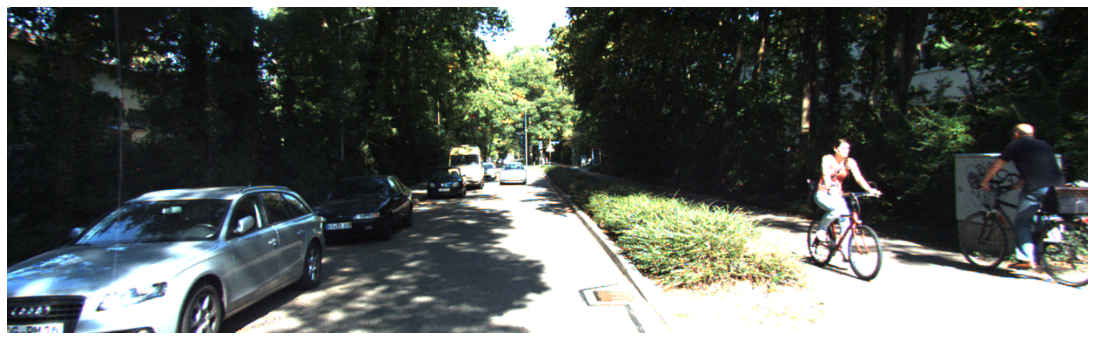

In [6]:
#Load image in RGB
img = cv2.cvtColor(cv2.imread(image_file),  cv2.COLOR_BGR2RGB)
#Let see the image dimensions
print(img.shape)
#Display image
plt.figure(figsize=(20, 6))
plt.imshow(img)
plt.axis("off")
plt.show()

## Camera Field of View (FOV) and Its Implications on LiDAR-Camera Data Fusion

### Constraints Imposed by Camera FOV on Projected 3D Points

When projecting 3D points from LiDAR data onto the image plane, a significant challenge encountered is the limitation imposed by the camera's Field of View (FOV). A notable proportion of these points may fall outside the dimensions of the captured image due to the restricted FOV of the camera. This phenomenon is particularly evident in datasets like KITTI, where the LiDAR system provides 360-degree point cloud scans.

### The Impact of FOV Limitations on LiDAR-Camera Fusion

This limitation is critical in LiDAR-camera data fusion processes, as points that do not align within the camera's FOV are essentially excluded from the fusion analysis. It underscores a fundamental constraint in such fusion techniques — the dependence on the camera's FOV. While it is theoretically possible to achieve a 360-degree camera FOV through meticulous calibration, practical implementations often face limitations.

### Focusing on the Fusion-Feasible Subset

In light of these constraints, our analysis will concentrate on the subset of the point cloud that falls within the FOV of the camera. This approach allows for a more focused and accurate assessment of LiDAR-camera data fusion capabilities, adhering to the realistic boundaries set by the camera's FOV.


Lets selected points in the field of view of the camera. The FOV of the camera is defined by the image dimensions such that

`xmin, ymin, xmax, ymax = (0, 0, img.shape[1], img.shape[0])`


We need to load the camera calibrations which is already a function in the `data_fusion_utils.py` defined as `load_calibrations`, we will also use `project_points` helper function to project our lidar points from 3D to 2D. 


In [8]:
# Lets Set frustum indices (fov)
xmin, ymin, xmax, ymax = (0, 0, img.shape[1], img.shape[0])

# Load projection matrices 
P, R_0, R_t = load_calibrations()

# To be able to index we need to project the points 
Y = project_points(P, R_0, R_t, X)

# Lets get the indces of the points Y in the FOV of camera
indices_frustum = np.where((Y[:, 0] >= xmin) & (Y[:, 1] >= ymin) & (Y[:, 0] <= xmax) & (Y[:, 1] <=ymax))[0]

# Use these indices to index the point cloud
point_cloud_fov = point_cloud.select_by_index(indices_frustum)
#Paint this point cloud green
point_cloud_fov.paint_uniform_color([0,1,0])

#Visualize point cloud
visualize_cloud([point_cloud_fov])

Matrix R0 (3, 3):
[[ 9.998817e-01  1.511453e-02 -2.841595e-03]
 [-1.511724e-02  9.998853e-01 -9.338510e-04]
 [ 2.827154e-03  9.766976e-04  9.999955e-01]]
Matrix P (3, 4):
[[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]
Matrix R (3, 3):
[[ 7.533745e-03 -9.999714e-01 -6.166020e-04]
 [ 1.480249e-02  7.280733e-04 -9.998902e-01]
 [ 9.998621e-01  7.523790e-03  1.480755e-02]]
Vector t (3, 1):
[[-0.00406977]
 [-0.07631618]
 [-0.2717806 ]]
Matrix R|t (3, 4):
[[ 7.533745e-03 -9.999714e-01 -6.166020e-04 -4.069766e-03]
 [ 1.480249e-02  7.280733e-04 -9.998902e-01 -7.631618e-02]
 [ 9.998621e-01  7.523790e-03  1.480755e-02 -2.717806e-01]]


### Output

![OUTPUT](../Doc_Images/DATAFUSION_DOC_IMAGES/output_2.png)

## Aligning LiDAR and Camera Data: Addressing Projection Ambiguities

### Culling LiDAR Points for Precise Projection
When we subset the LiDAR point cloud based solely on the camera's field of view, we capture points both in front of and behind the camera. This occurs because projecting 3D points onto a 2D plane inherently creates ambiguity: points with opposite positions in 3D can project onto the same pixel. If we proceed with PointPainting using this entire LiDAR scan, we risk incorrectly labeling points that don't align with objects captured by the camera

To ensure accurate labeling, we must carefully remove points behind the camera. This is where the KITTI setup's coordinate system comes in handy:

![Kitti Set-Up](../Doc_Images/DATAFUSION_DOC_IMAGES/kitty_setup.png)

In this setup, the LiDAR's x+ axis points in the same direction as the camera's field of view. This valuable information allows us to precisely subset only the LiDAR points that correspond to objects captured in the image.


### Visualizing the Image Frustum: The Pyramid-Shaped Subset

Once we filter out the extraneous points, we're left with a pyramid-shaped subset of the LiDAR scan. This distinct shape is known as the image frustum, representing the entire 3D region captured within the camera's field of view and projected onto the 2D image plane.

Understanding and accounting for the image frustum is crucial for accurate 3D object detection and perception tasks that rely on LiDAR-camera fusion. By carefully aligning these two sensor modalities, we unlock a more comprehensive and accurate understanding of the 3D environment.

Let us now subset the correct points 

In [9]:
#Select points within frontal 180 degrees by getting rid of those points in -x direction in keeping the +x 
indices_180 = np.where(X[:, 0] >=  0)[0]
X_180 = X[indices_180]
point_cloud_180 = point_cloud.select_by_index(indices_180)
point_cloud_180.paint_uniform_color([1,1,1])
visualize_cloud([point_cloud_180])

### Output

![OUTPUT](../Doc_Images/DATAFUSION_DOC_IMAGES/output_3.png)

Now that we have subsetted all the frontal 180 degree we will now get the points that are within the cameres frustum

In [11]:
# Frist Project points 
Y = project_points(P, R_0, R_t, X_180)
# Get the indices within frustum
indices_frustum = np.where((Y[:, 0] >= xmin) & (Y[:, 1] >= ymin) & (Y[:, 0] <= xmax) & (Y[:, 1] <=ymax))[0]
print(indices_frustum, len(indices_frustum))

[    0     1     2 ... 45098 45099 45100] 19167


In [14]:
#Subset points and print shapes of all the X points once subsetted
X_frustum = X_180[indices_frustum]
print(X.shape, X_180.shape, X_frustum.shape)

(122595, 3) (60881, 3) (19167, 3)


In [15]:
# Use indcies to subset point cloud and visualize
point_cloud_frustum = point_cloud_180.select_by_index(indices_frustum)

In [17]:
#Paint the green 
point_cloud_frustum.paint_uniform_color([0, 1, 0])

#Lets visuzlize the point cloud on top of the 180 point cloud scan that is painted white
visualize_cloud([point_cloud_frustum, point_cloud_180])



We can see on the output below that we have now sucessfully obtained points within the point cloud that are within the image frustum and contain objects captured by the image

### Output

![OUTPUT](../Doc_Images/DATAFUSION_DOC_IMAGES/output_4.png)

# Frontal Projection 

We can create an lidar mask image of all the points in the frustum similar to how we did in Part I. Lets create a lidar mask

(375, 1242)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[512.70170133 156.08574921]
 [511.53722648 156.10755205]
 [509.21785957 156.13939457]
 ...
 [619.62855429 371.93151005]
 [617.28009604 372.06738577]
 [616.10681656 371.97740903]]


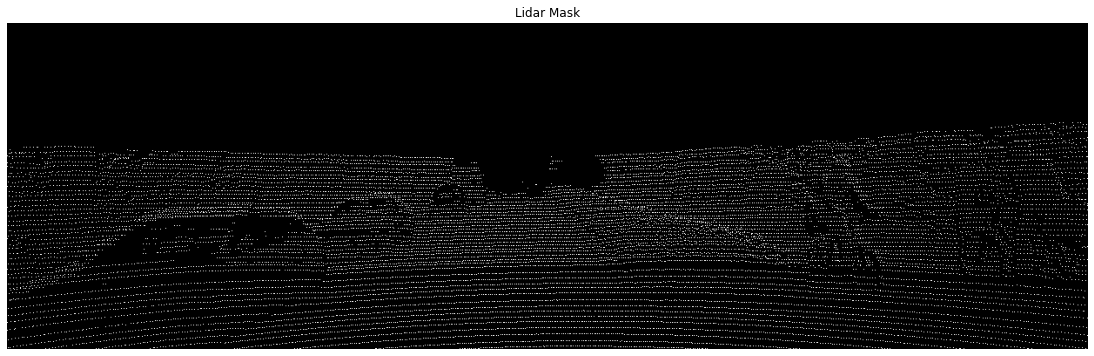

In [19]:
# Lets create an emtpy zeros numpy array using the first channel of img 
lidar_mask = np.zeros_like(img[:, :, 0])
print(lidar_mask.shape)
print(lidar_mask)

# We still need the X_frustum points to be projected unto 2D 
Y_frustum = project_points(P, R_0, R_t, X_frustum)
print(Y_frustum)

#We will iterate over these pixel however these are floating point and must be converted to integers for this work, remember images are in [y, x] format 
for x, y in Y_frustum.astype(np.uint16):
    #assing pixel location of projected 3D point to 1
    lidar_mask[y, x] =  1

#Plot image
plt.figure(figsize=(20, 6))
plt.imshow(lidar_mask, cmap='gray')
plt.title("Lidar Mask")
plt.axis("off")
plt.show()

# Advanced Image Semantic Segmentation for PointPainting

### Integrating Mask R-CNN V2 for Enhanced Semantic Segmentation

In this section, we delve into a pivotal stage of the PointPainting process: the application of a semantic segmentation neural network to our imagery data. The original PointPainting methodology utilizes DeepLabv3+, a robust segmentation model available in PyTorch. However, my experimentation revealed that its pre-trained weights exhibited suboptimal performance on the KITTI dataset used for this course.

Given these findings, I have pivoted to the `Mask R-CNN V2`. This model represents an evolution of Faster R-CNN, augmenting it with an additional branch specifically designed for segmentation mask prediction in each Region of Interest (RoI). It seamlessly integrates classification, bounding box regression, and segmentation tasks. The incorporation of a ResNet-50-FPN as its backbone elevates its feature extraction capabilities, making it particularly adept for our purposes.

### Why Mask R-CNN V2?

The selection of Mask R-CNN V2 for our project is principally motivated by its robust performance on the KITTI dataset, including when utilizing its pre-trained weights. This version of Mask R-CNN, enhanced with a sophisticated ResNet-50-FPN backbone, demonstrates exceptional adeptness in semantic segmentation. Such an ability is vital for the precise assignment of per-pixel labels in our images. Additionally, Mask R-CNN V2 offers a significant degree of flexibility in processing images of varying sizes. While it can handle diverse image dimensions, practical considerations such as memory constraints and processing efficiency may necessitate the resizing or downsampling of exceptionally large images. This flexibility in managing different image sizes allows us to maintain a balance between image integrity and computational efficiency

### Application in PointPainting

Our goal is to leverage Mask R-CNN V2 to generate precise semantic labels at the pixel level. These labels are instrumental in the subsequent 'decoration' of the LiDAR point cloud within the camera's field of view (or image frustum). By assigning each point in the cloud a class label based on the corresponding image pixel, we enrich the point cloud with a layer of semantic information, thereby enhancing the overall quality and utility of our fused dataset.

In [21]:
#Import maskrcnn_v2 an other torch libararies
import torch
import numpy as np
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.transforms import functional as F
from torchvision.transforms import transforms as T
import matplotlib.pyplot as plt
from PIL import Image

In [23]:
# Set needed transfomrations to pass through deeplab_v3
transform = T.ToTensor()
# Preprocess the image by converting to tensor usually in torch we need to add an extra batch dimension is not the case for Mask-RCNN
input_image = transform(img)
print(input_image.shape)
# Check if a GPU is available and if not, use a CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Load the pre-trained Mask R-CNN model and set it to eval mode
model = maskrcnn_resnet50_fpn_v2(MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT)
model.eval()

torch.Size([3, 375, 1242])
Device: cpu


C:\Users\adela\anaconda3\envs\ComputerVision\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

Now that we have the model let us infer on it

In [24]:
#Move input image to available device
input_image  = input_image.to(device)

# Get predictions
with torch.no_grad():
    prediction = model([input_image])
# The prediction is a list of dictionaries, and we can extract the masks, labels, and boxes, and confidence scores
pred_masks = prediction[0]['masks'].cpu().squeeze().numpy()
pred_labels = prediction[0]['labels'].cpu().numpy()
pred_scores = prediction[0]['scores'].cpu().numpy()

I have created dictionary that contains the numerical mapping of all coco classes to their corresponding label. It can be loaded in `coco_classes.json`. However, I have also created a function from `data_fusion_utils` as `get_coco_classes_and_color_map` that will return the coco classes dictionary and a custom color map for each class. 

In [25]:
#Get classes and color map per calss
coco_classes, coco_color_map = get_coco_classes_and_color_map()
print(coco_classes)
print("\n")
print(coco_color_map)

{0: 'background', 1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell p

Let us now view each of the masks along with its predication label and confidence of label

Class: person Confidence: 0.9988778233528137


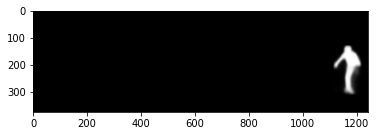

Class: person Confidence: 0.9974925518035889


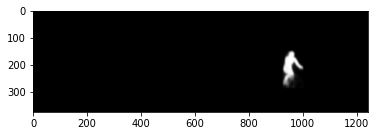

Class: car Confidence: 0.9971756935119629


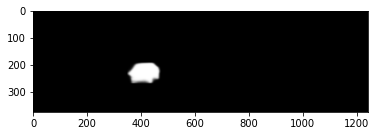

Class: car Confidence: 0.9971188306808472


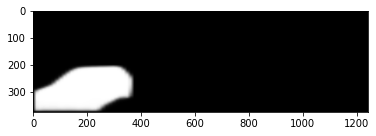

Class: car Confidence: 0.996431827545166


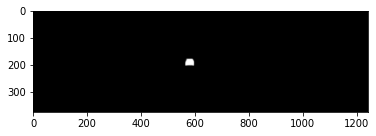

Class: bicycle Confidence: 0.9948322772979736


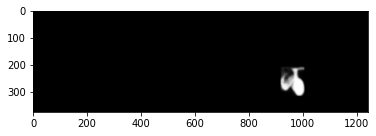

Class: car Confidence: 0.9943884015083313


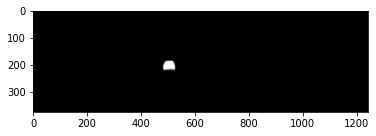

Class: bicycle Confidence: 0.9922688603401184


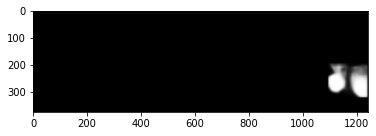

Class: car Confidence: 0.9887292981147766


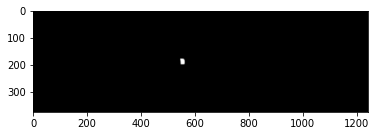

Class: truck Confidence: 0.8535704016685486


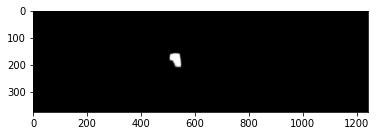

Class: car Confidence: 0.46641579270362854


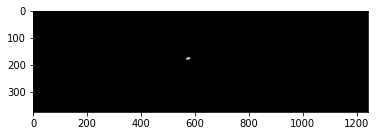

Class: car Confidence: 0.38262662291526794


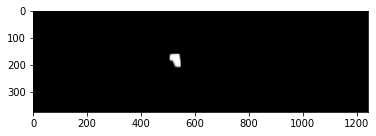

Class: car Confidence: 0.35416048765182495


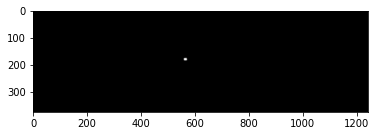

Class: bus Confidence: 0.2907188832759857


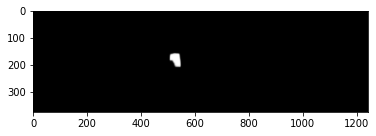

Class: traffic light Confidence: 0.20733675360679626


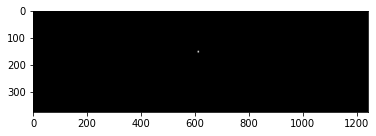

Class: bicycle Confidence: 0.16958768665790558


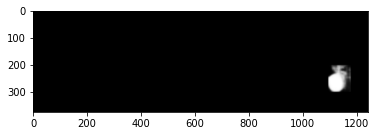

Class: motorcycle Confidence: 0.12392708659172058


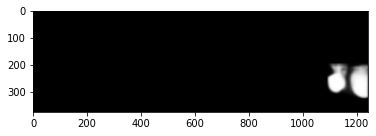

Class: handbag Confidence: 0.10812705010175705


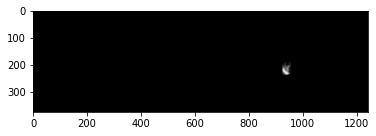

Class: car Confidence: 0.10283166170120239


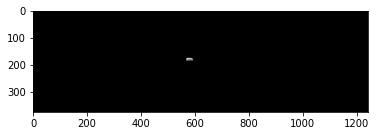

Class: bicycle Confidence: 0.10008887201547623


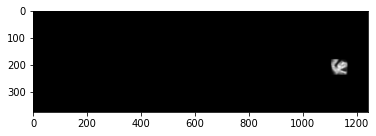

Class: car Confidence: 0.05874478071928024


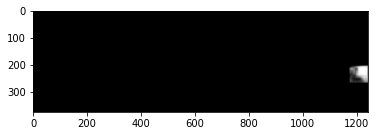

Class: car Confidence: 0.05573908984661102


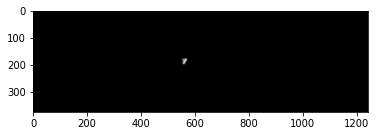

Class: traffic light Confidence: 0.053665414452552795


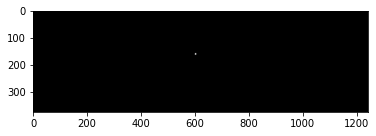

Class: car Confidence: 0.050372879952192307


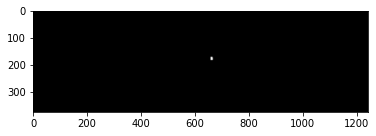

In [26]:
for mask, label, score in zip(pred_masks, pred_labels, pred_scores):
    print(f"Class: {coco_classes[label]} Confidence: {score}")
    plt.imshow(mask, cmap='gray')
    plt.show()
    

In [28]:
#It appears this is sorted by confidence scores we want to only use those we are highly confident in 

# Set confidence thresh
confidence_threshold = 0.85
# Get high conf indices
high_conf_indices = np.where(pred_scores >= confidence_threshold)[0]
# Subset output 
pred_masks = pred_masks[high_conf_indices]
pred_labels = pred_labels[high_conf_indices]
pred_scores = pred_scores[high_conf_indices]

Lets once again review those that we will use for our semantic map

Class: person Confidence: 0.9988778233528137


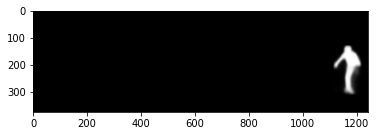

Class: person Confidence: 0.9974925518035889


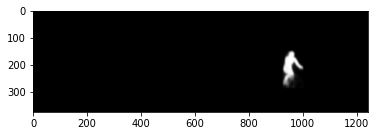

Class: car Confidence: 0.9971756935119629


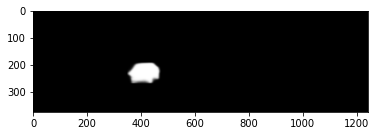

Class: car Confidence: 0.9971188306808472


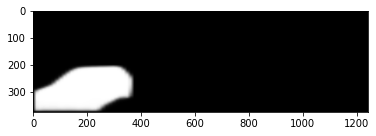

Class: car Confidence: 0.996431827545166


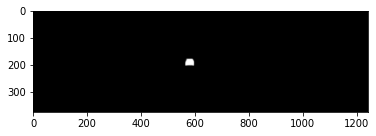

Class: bicycle Confidence: 0.9948322772979736


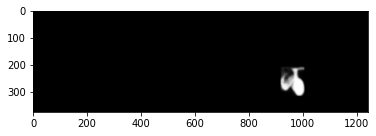

Class: car Confidence: 0.9943884015083313


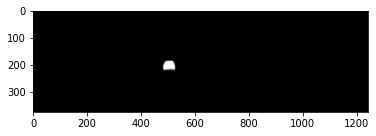

Class: bicycle Confidence: 0.9922688603401184


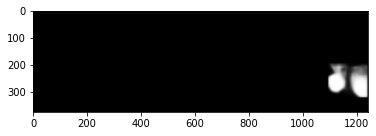

Class: car Confidence: 0.9887292981147766


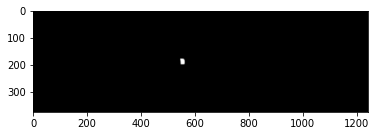

Class: truck Confidence: 0.8535704016685486


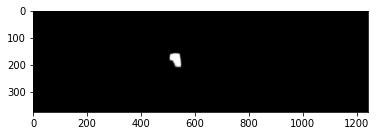

In [29]:
for mask, label, score in zip(pred_masks, pred_labels, pred_scores):
    print(f"Class: {coco_classes[label]} Confidence: {score}")
    plt.imshow(mask, cmap='gray')
    plt.show()

## Semantic Image Creation

Lets now use all this information to create the semantic image for visualization purposes. 

Mask datatype: float32



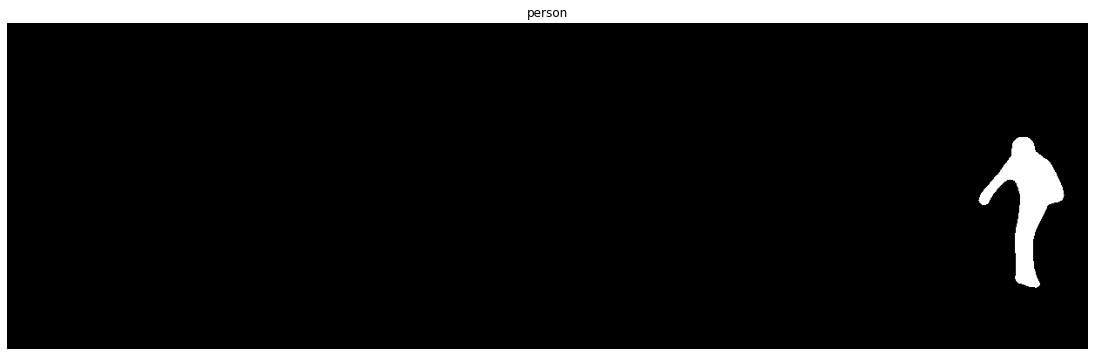

In [31]:
#Lets create an empty image to dispaly the semantic map
semantic_image = np.zeros_like(img)
semantic_image.shape

# if we print out one of the masks we can see they are float point values we need to conver this to int, lets look at the first mask
mask = pred_masks[0]
print(f"Mask datatype: {mask.dtype}\n")
# However, we cannot just do .astype(np.uint8) as this wil set all values to zero, thus to create a true binary image we threshold 
mask = mask > 0.5
# Now have a true and false, lets convert to ones and zeros
mask = mask.astype(np.uint8)


#Let us now print out the mask
plt.figure(figsize=(20, 6))
plt.imshow(mask, cmap='gray')
plt.title(coco_classes[pred_labels[0]])
plt.axis("off")
plt.show()

Lets now color this label using the customized `coco_color_map`, we use our binary mask to index our image, thus where mask is one then we assign our empty sementic image our color map based on the label. 

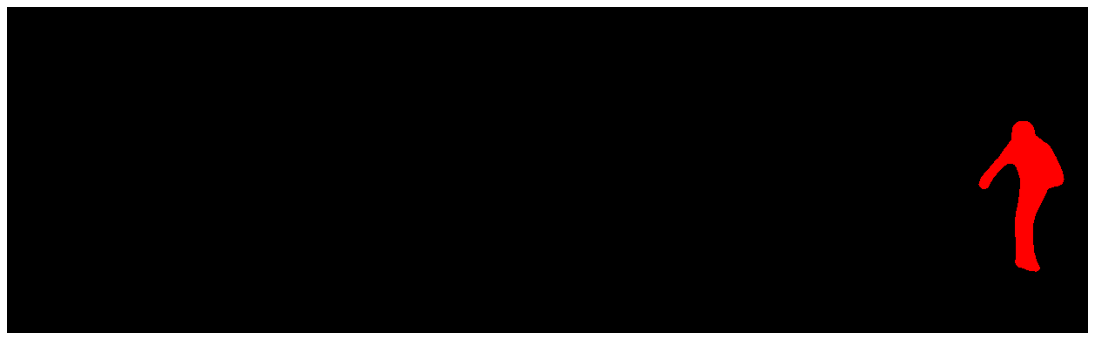

In [32]:
#Set color label where mask is one
semantic_image[mask == 1] = coco_color_map[pred_labels[0]]
plt.figure(figsize=(20, 6))
plt.imshow(semantic_image)
plt.axis("off")
plt.show()

Lets now create a semantic map of the entire image as well as obtain a per pixel map  or score that has the class label for each pixel in the image, we will use this later on. 

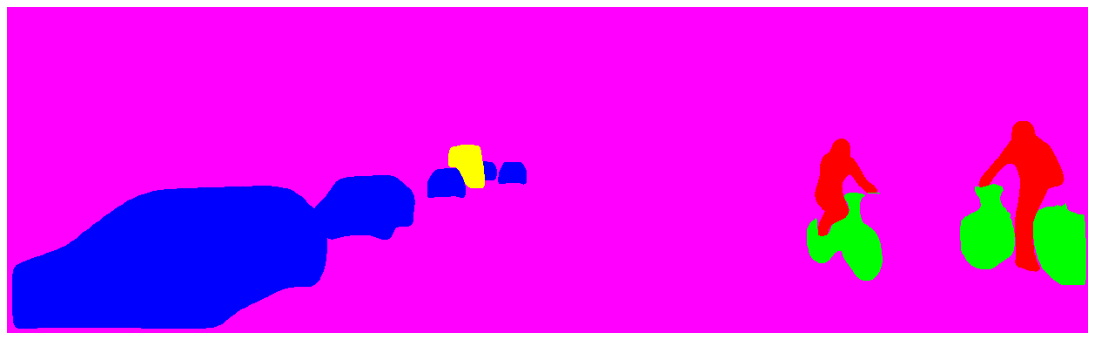

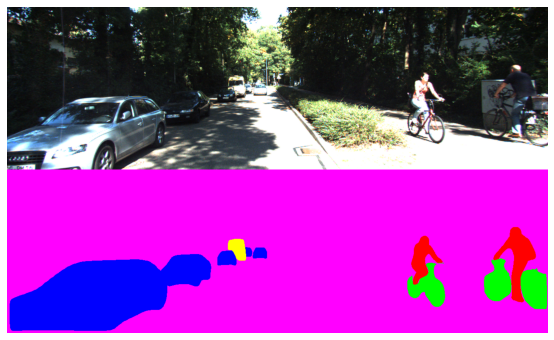

In [34]:
#Create sematic map
semantic_image = np.zeros_like(img)
#Create a per pixel score of class of only 1 channel this will be used decorate the points cloud later on
per_pixel_score = np.zeros_like(pred_masks[0])

#loop over predicted masks and labels
for mask, label in zip(pred_masks, pred_labels):
    #Threshold mask as output was float32 then convert to np.uint8
    mask = mask  > 0.5
    mask = mask.astype(np.uint8)
    semantic_image[mask == 1] = coco_color_map[label]
    per_pixel_score[mask == 1] = label

#Set any left over black pixels from 0 to calss 0 which is just background or noise
# This will set all pixels that are black (0, 0, 0) to white (255, 255, 255)
semantic_zeros = np.all(semantic_image == 0, axis=-1)
semantic_image[semantic_zeros] = coco_color_map[0]
#Per pixel score background/noise is already zeros so there is no need to update


    
#Plot image
plt.figure(figsize=(20, 6))
plt.imshow(semantic_image)
plt.axis("off")
plt.show()


#Plot original image and semantic image together
#Lets stack them together
plt.figure(figsize=(20, 6))
plt.imshow(np.vstack((img, semantic_image)))
plt.axis("off")
plt.show()

# Lidar Decoration

We will now decorate the point cloud using the `per_pixel_score` to map each pixel label to a lidar point projected unto 2D 

[0. 1. 2. 3. 8.]


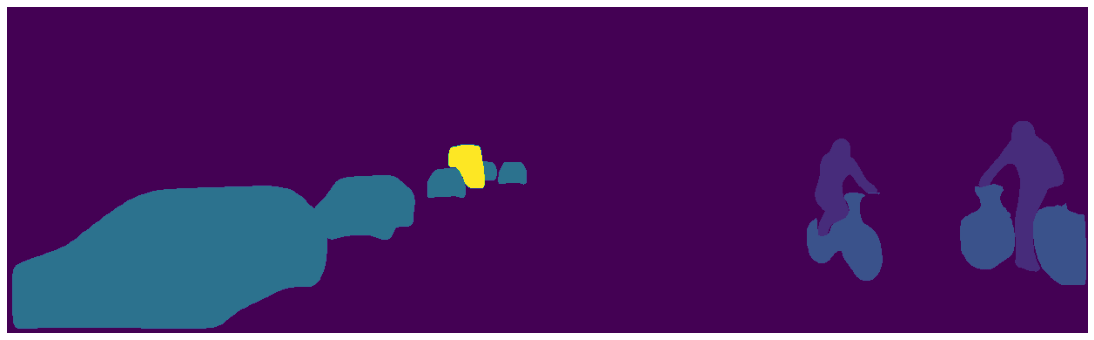

In [36]:
#Let us now decorate the point cloud lets first review the unique labels
print(np.unique(per_pixel_score))


#Lets plot the per_pixel_score
plt.figure(figsize=(20, 6))
plt.imshow(per_pixel_score)
plt.axis('off')
plt.show()

Recall `Y_frustum` and `X_frustum` are already defined. Our pixel mapping only works with integers hence all points projected into 2D in `Y_frustum` are floating points. These must be converted to integers to be able to index properly. 

In [38]:
#Covert projected points to inter values
Y_frustum_int = Y_frustum.astype(np.uint16)
print(Y_frustum_int)

[[512 156]
 [511 156]
 [509 156]
 ...
 [619 371]
 [617 372]
 [616 371]]


### Point Cloud Decoration

This is the main algorithm to decorate the point cloud. Looping is not the most efficient way to do this, we can optimize this using multithreading or processing or other numpy libraries. However, I prefer this way because it provides more insight on how the point cloud is being decorated. I will describe the algorithm and feel free to optimize it from your end. 

1. Create an empty `labels` int numpy vector of the same size as the number of points in our lidar point cloud.
2. We iterate starting from the top left corner of the image we start at the height which is `y` then we iterate over the width or `x`. Hence, we will be at each pixel coordinate location (y,x) of the image
3. At each pixel coordinate location (y, x) we get the indices of all the lidar pixel coordinates from `Y_frustum_int` that are equal to the current (y, x) pixel coordinate.
4. We then use those `indices` to set all values in `labels` the the class label defined by `per_pixel_score` at the current pxiel coordinate.  

In [39]:
#Let us now assign a per point semantic label to the lidar point cloud
labels = np.zeros(Y_frustum_int.shape[0]).astype(np.uint16)
for y in range(per_pixel_score.shape[0]):
    for x in range(per_pixel_score.shape[1]):
        #Get indices where any pixels in Y_frustum_int are the current y,x pixel
        indices = np.where((Y_frustum_int[:, 0] == x) & (Y_frustum_int[:, 1] == y))[0]
        #Set labels at incdices with their class label defined by per_pixel score
        labels[indices]  = per_pixel_score[y, x]
        

If this is correct then our unique values in per_pixel_score should equal the unique values in labels

In [40]:
print(f"Values equal? -- > {np.unique(labels) == np.unique(per_pixel_score)}") 

Values equal? -- > [ True  True  True  True  True]


Now we expect the number of labels to equal the total number of points in our 3D lidar point cloud, we can see below that this is the case!

In [41]:
print(len(labels))
print(X_frustum.shape)

19167
(19167, 3)


## Decorate Lidar Mask

Lets use these labels to decorate a lidar image. We will use `cv2.circle` from openCV for better visualization. 

(375, 1242, 3)


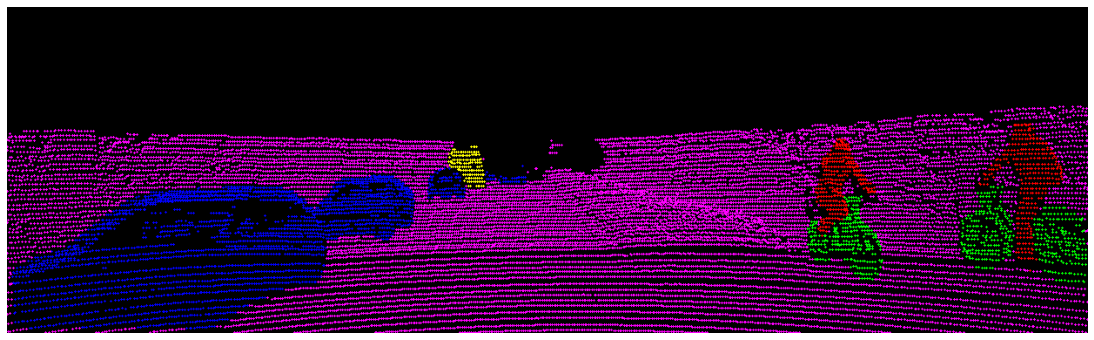

In [43]:
#Now lets create an empty lidar image, in this case it must be 3 channels since we are adding color
lidar_image = np.zeros_like(img)
print(lidar_image.shape)
#Iterate over integer Y_frustum use the pixel location to assign color to the empty image using customized color map
for i, (x, y) in enumerate(Y_frustum_int):
    #Draw a circle with radius 1 at (x, y) position use custom coco color map
    cv2.circle(lidar_image, (x, y), radius=1, color=coco_color_map[labels[i]], thickness=-1)  # thickness=-1 fills the circle


#Plot image
plt.figure(figsize=(20, 6))
plt.imshow(lidar_image)
plt.axis("off")
plt.show()

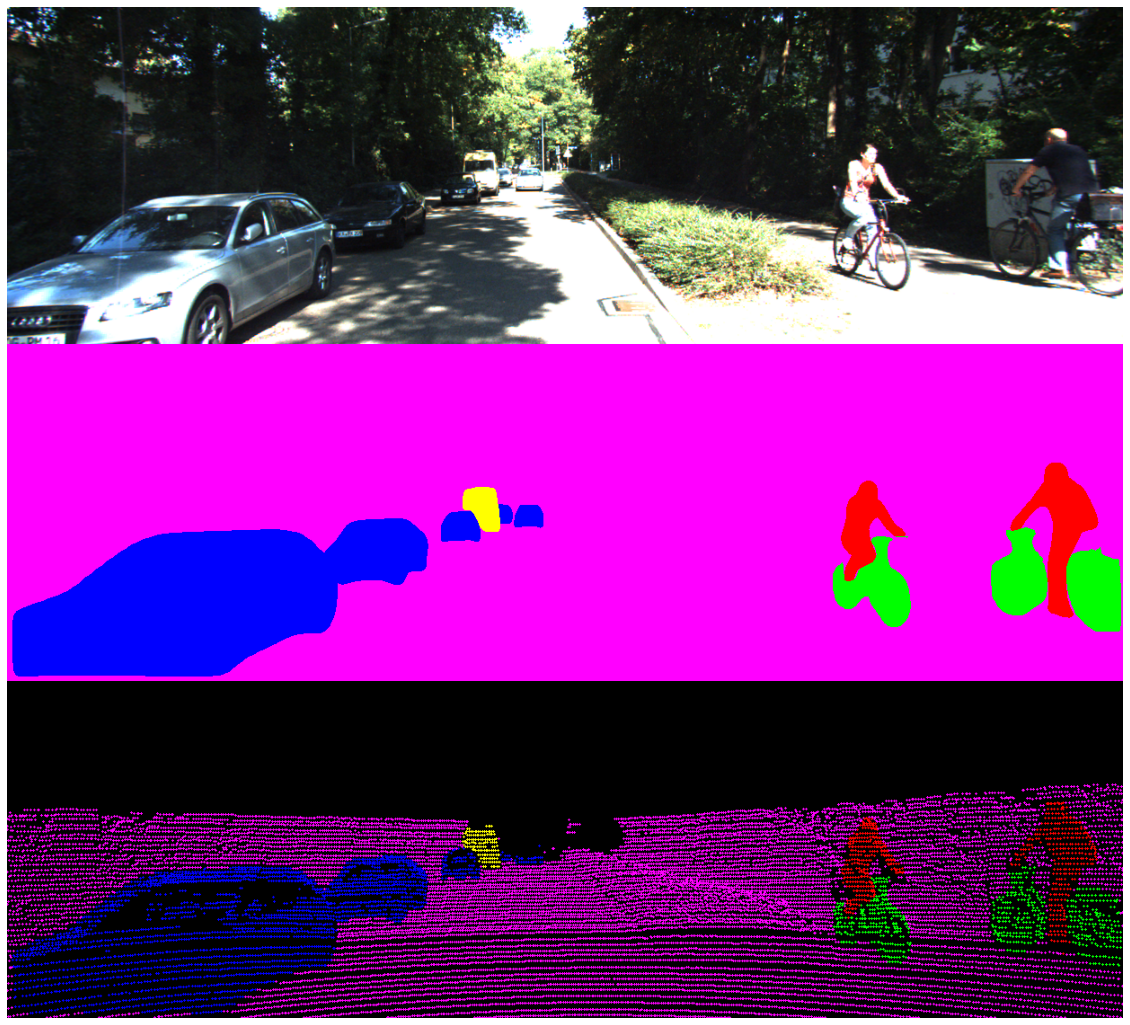

In [44]:
#Lets stack them together
plt.figure(figsize=(20, 20))
plt.imshow(np.vstack((img, semantic_image, lidar_image)))
plt.axis("off")
plt.show()

## Decorate 3D Point Cloud

Lets use the labels to decorate the point cloud. Since `Y_frustum` and `X_frustum` have the same indexing then `labels` is directly proportional to `X_frustum` indices. To do this is simple we create a color map using our label values and custom color map. 

In [45]:
#Lets ensure original point cloud is white we will use the entire scan for better perspective
point_cloud.paint_uniform_color([1, 1, 1])
#Create a color mapping using customized color map
lidar_color_map = np.array([coco_color_map[label] for label in labels])
#Add colors to the frustum point cloud
point_cloud_frustum.colors = o3d.utility.Vector3dVector(lidar_color_map)
#We will visualize the decorated point cloud on top of the entire lidar scan. 
visualize_cloud([point_cloud_frustum, point_cloud])

### Outputs

![OUTPUT](../Doc_Images/DATAFUSION_DOC_IMAGES/output_5.png)

![OUTPUT](../Doc_Images/DATAFUSION_DOC_IMAGES/output_6.png)

![OUTPUT](../Doc_Images/DATAFUSION_DOC_IMAGES/output_7.png)

An insightful observation to note is that certain points located behind objects are also semantically labeled (or 'decorated'). This phenomenon is attributed to the perspective projection mechanism inherent in camera optics. In perspective projection, visual information is concentrated into a confined region, and as the camera's frustum expands outward, points situated farther away in the frustum may align with the same pixel location as objects closer to the camera. This overlapping of distant and near points in the pixel space leads to some points behind objects receiving labels that actually pertain to foreground objects.

Addressing this challenge requires advanced techniques. One potential approach could be unsupervised clustering, which might help in differentiating between foreground and background points based on their spatial and semantic characteristics. Other techniques could also be explored to refine the accuracy of point cloud labeling. However, delving into these solutions is beyond the scope of this course. Nonetheless, it is an important consideration for future enhancements in LiDAR-camera fusion methodologies, especially for applications demanding high precision in semantic labeling.

In [48]:
#Lets Create the final matrix 
final_matrix = np.hstack((X_frustum, np.array(labels).reshape(-1,1)))

print(f"Orignal Lidar Matrix {X_frustum.shape} || Final Lidar Matrix {final_matrix.shape}")


Orignal Lidar Matrix (19167, 3) || Final Lidar Matrix (19167, 4)


### Final Matrix

We have sucessfully transformed our `NxL` matrix to a `Nx(L + C)` matrix!!!!

Now the next steps in the point painting paper involve feeding the enhanced point labeled matrix into a PointPillars network for 3D object detection. However, here we are only intrested in the data fusion concept. We first need to review `PointNet` and `PointNet++` before getting into point pillars.  


# PointPainting 

Now that we have everything we need lets I have created a python class that uses all the functions needed to peform pointating lets go over it. 

In [55]:
#Lets import the class!
%load_ext autoreload
%autoreload 2
from point_painter import PointPainter

Next we instantiate the class we provide the following input parameters `P`, `R_0`, `R_t` and `conf`for confidence optional as this is already set to 0.85

In [56]:
#Instantiate point painter class
cloud_painter = PointPainter(P, R_0, R_t)

### Get MaskRCNN predictions
Lets go over the different methods, first we have `get_maskrcnn_predictions` this are just the simple output predictions of maskrcnn given the confidence using an input image. This will return `pred_mask`, `pred_labels`, `pred_scores`

In [57]:
pred_masks, pred_labels, pred_scores = cloud_painter.get_maskrcnn_predictions(img)

In [58]:
print(pred_masks.shape)
print([cloud_painter.coco_classes[label] for label in pred_labels])
print(pred_scores)

(10, 375, 1242)
['person', 'person', 'car', 'car', 'car', 'bicycle', 'car', 'bicycle', 'car', 'truck']
[0.9988778  0.99749255 0.9971757  0.99711883 0.9964318  0.9948323
 0.9943884  0.99226886 0.9887293  0.8535704 ]


### Get Semantic Image and Per Pixel Score

The `get_semantic_image_and_per_pixel_score` will provide us with the segmantic color image and pixel score image map. It has input arguments of `image`, `pred_masks`, and `pred_labels` if no argument is provided for `pred_mask` or `pred_labels` the function will infer on the image first using MaskRCNN. However, here we already have these values. 

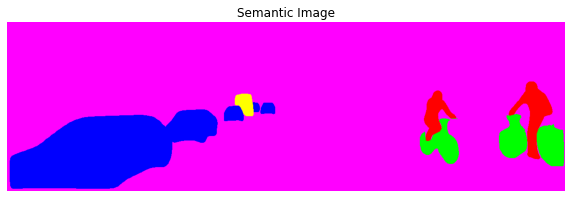

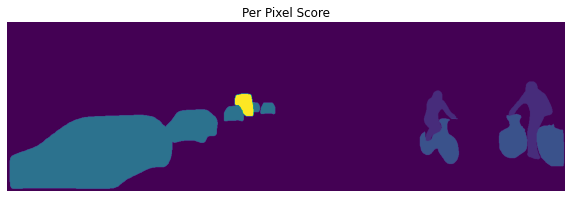

In [59]:
semantic_image, per_pixel_score =  cloud_painter.get_semantic_image_and_per_pixel_score(img, pred_masks, pred_labels)

#Plot images
plt.figure(figsize=(10, 6))
plt.imshow(semantic_image)
plt.title('Semantic Image')
plt.axis("off")
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(per_pixel_score)
plt.title('Per Pixel Score')
plt.axis("off")
plt.show()

### Decorate Point Cloud

The `decorate_point_cloud` method will decorate the point cloud and provide you with the lidar `labels`, `lidar_color_map`, `lidar_image`
All we have to do is provide the image, lidar points and `per_pixel_score` if per_pixel_score is not defined or is emtpty then the function will infer on the image to get the `per_pixel_score`

In [60]:
labels, lidar_color_map, lidar_image = cloud_painter.decorate_point_cloud(img, X_frustum, per_pixel_score)

[0 1 2 3 8]
[[255   0 255]
 [255   0 255]
 [255   0 255]
 ...
 [255   0 255]
 [255   0 255]
 [255   0 255]]


(-0.5, 1241.5, 374.5, -0.5)

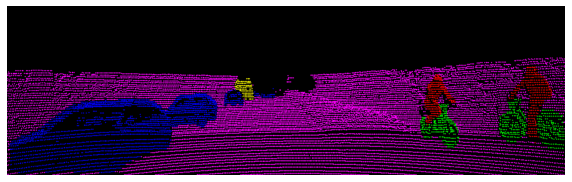

In [61]:
print(np.unique(labels))
print(lidar_color_map)
plt.figure(figsize=(10, 6))
plt.imshow(lidar_image)
plt.axis('off')

### Run Full Stack

The `paintCloud` is the main method it runs all the other functions from inference to point painting and ruturns a dictionary with everthing. Its input parameters are just the image and the lidar points

In [62]:
point_painting_detections = cloud_painter.paintCloud(img, X_frustum)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dict_keys(['pred_mask', 'pred_labels', 'pred_scores', 'semantic_image', 'per_pixel_score', 'lidar_labels', 'lidar_color_map', 'lidar_image'])


(-0.5, 1241.5, 1499.5, -0.5)

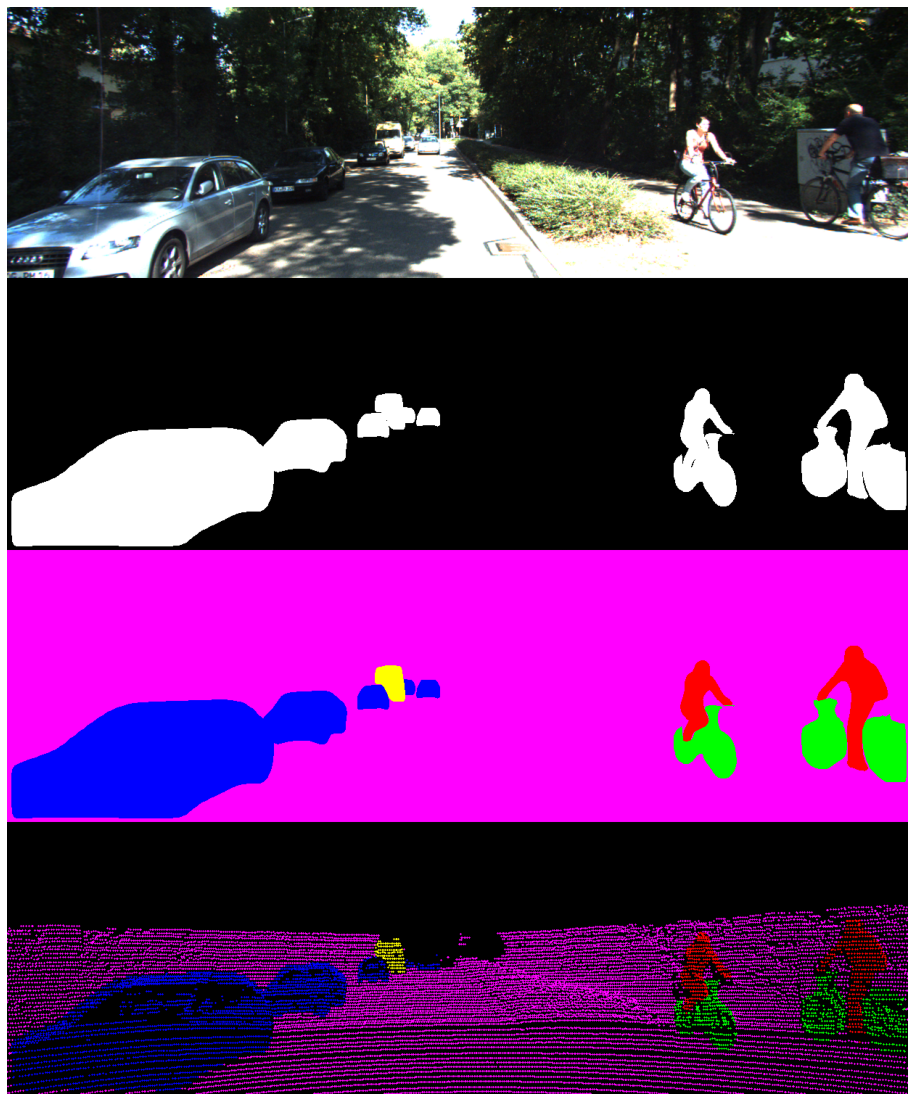

In [63]:
print(point_painting_detections.keys())
#Lets stack the image from img, per_pixel_score, segementation, and lidar_image
full_stack_image = np.vstack((img, np.stack((point_painting_detections['per_pixel_score'],)*3, axis=-1)*255, 
                             point_painting_detections['semantic_image'], point_painting_detections['lidar_image']))/255
plt.figure(figsize=(40, 20))
plt.imshow(full_stack_image)
plt.axis('off')


# GIF Creation

Lets create a video that shows all these images in motion, we already have the `PointPainter` class instantiated

In [120]:
#Lets create a gif video 
from tqdm import tqdm
#Create a list of gif images 
gif_images = []
for i in tqdm(range(len(image_file_names))):
    #Load image
    IMAGE = cv2.cvtColor(cv2.imread(image_file_names[i]),  cv2.COLOR_BGR2RGB)
    #Load lidar
    LIDAR = np.asarray(o3d.io.read_point_cloud(lidar_file_names[i]).points)
    #Select points within 180 degrees
    indices_180 = np.where(LIDAR[:, 0] >=  0)[0]
    LIDAR_FOV_180 = LIDAR[indices_180]
    #Select Frustum 
    Y = project_points(P, R_0, R_t, LIDAR_FOV_180)
    indices_frustum = np.where((Y[:, 0] >= xmin) & (Y[:, 1] >= ymin) & (Y[:, 0] <= xmax) & (Y[:, 1] <=ymax))[0]
    X_FRUSTUM = LIDAR_FOV_180[indices_frustum]
    
    #Get all detections
    detections = cloud_painter.paintCloud(IMAGE, X_FRUSTUM)
    SEMANTIC_IMAGE = detections['semantic_image']
    LIDAR_IMAGE = detections['lidar_image']

    #Lets add top left text label
    # Define the text properties
    position = (10, 30)  # Position of text (x, y) from the top-left corner
    font = cv2.FONT_HERSHEY_SIMPLEX  # Font type
    font_scale = 1  # Font size
    thickness = 2  # Font thickness
    
    text = "Original Image" 
    color = (255, 255, 255)
    # Add text to the image
    cv2.putText(IMAGE, text, position, font, font_scale, color, thickness)

    text = "MaskRCNN Semantic Image" 
    color = (0, 0, 0)
    # Add text to the image
    cv2.putText(SEMANTIC_IMAGE, text, position, font, font_scale, color, thickness)

    text = "Decorated Lidar Image" 
    color = (255, 255, 255)
    # Add text to the image
    cv2.putText(LIDAR_IMAGE, text, position, font, font_scale, color, thickness)

    

    
    
    
    #Append and stack below original image
    full_stack_image = np.vstack((IMAGE, SEMANTIC_IMAGE, LIDAR_IMAGE))
    gif_images.append(full_stack_image)

100%|██████████████████████████████████████████████████████████████████████████████████| 86/86 [13:28<00:00,  9.40s/it]


In [121]:
# Save the images as a GIF
import imageio
#Set duration of each each frame 
frame_duration = 1
imageio.mimsave("semantic_scene_map.gif", gif_images, duration=frame_duration, loop=0)

# Output

<img src="semantic_scene_map.gif" alt="Semantic-Map" style="loop:infinite;">